## Calculate Cloud Fractions

In [150]:
import json
import glob
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd    
import xarray as xr

import seaborn as sns

In [151]:
#data_dir = '/home/hanna/MS-suppl/files/'
data_dir = '/uio/hume/student-u89/hannasv/MS-suppl/'
sat_dir = '/uio/lagringshotell/geofag/projects/miphclac/hannasv/'
save_dir = '/uio/lagringshotell/geofag/students/metos/hannasv/satelite_data/'

In [152]:
def read_dlon_dlat(data_dir):
    
    nc_files = glob.glob(data_dir+'*small*.json')    
    #print(nc_files[-1])
    with open(nc_files[-1]) as f:
        d =  json.load(f)
    
    d_phi      = d['dphi'] 
    d_theta    = d['dtheta'] 
    cell_areas = d['cell_area']
    lat_array  = d['lat'] 
    lon_array  = d['lon']
    return d_phi, d_theta, cell_areas, lat_array, lon_array

In [153]:
d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat(data_dir)

In [154]:
def clean_file(satfil):
    if satfil.split('.')[-1] == 'grb':
        cloudMask = xr.open_dataset(satfil, engine = 'cfgrib')
        o = cloudMask['p260537'].values.reshape( (3712, 3712) )
        
        o[o>=3.0]=np.nan
        o[o==1.0]=0
        o[o==2.0]=1.0
    else:
        cloudMask = xr.open_dataset(satfil)
        o = cloudMask['cloudMask'].values.reshape( (3712, 3712) )
    return o

In [155]:
def area_grid_cell(c_lat, d_lat, d_lon):
        R = 6371000  # in M
        # area er egentlig R**2
        area = R*(np.sin((c_lat + d_lat)*np.pi/180) - np.sin((c_lat - d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
        return np.abs(area)

In [156]:
def get_dict_with_all_keys():
    ex_fil = glob.glob(data_dir + '*ERA5*.json')
    #print(ex_fil)
    merged_dict = {}
    
    for fil in ex_fil:
        with open(fil, 'r') as f:
            data_grid = json.load(f)
        merged_dict.update(data_grid)
    return merged_dict

In [157]:
data_dict = get_dict_with_all_keys()

In [213]:
def calc_fraction_one_cell(lat = '30.25', lon = '19.25', cmk = None, data = None):

    if data:
        ## Improvements : This should read the files. 
        if lon == '0.0':
            ex = data[lat]['0.5']
        else:
            ex = data[lat][lon]
        fraction = 0.0

        ERA_area = area_grid_cell(float(lat), 0.25/2, 0.25/2)
        SAT_area = 0.0

        for key, item in ex.items():
            index = item['index']
            area  = item['area']

            if len(index) == len(area):
                # , "len index, len are = {}, {}".format(len(index), len(area))
                SAT_area += np.nansum(area)
                #print('nans area')
                #print()
                if np.isnan(np.array(area)).sum() > 0:
                    print('Returns nan for lat {}, lon {}'.format(lat, lon))
                #fraction += np.nansum(np.array(area)*np.array(cmk[index]) )
                add = np.nansum(np.array(cmk[index]))
                #print(add)
                fraction += add
            else:
                print('Returns nan for lat {}, lon {}'.format(lat, lon))
                return np.nan, (lat, lon)
        return np.mean(fraction), SAT_area
    else:
        print('Please send data as a attribute.')
        return

In [214]:
def calc_fraction_one_cell_only(lat = '30.25', lon = '19.25', cmk = None, data = None):

    if data:
        ## Improvements : This should read the files. 
        if lon == '0.0':
            ex = data[lat]['0.5']
        else:
            ex = data[lat][lon]
        
        fraction = 0.0

        ERA_area = area_grid_cell(float(lat), 0.25/2, 0.25/2)
        SAT_area = 0.0
        #cmk = np.random.randint(low = 0, high=2, size = len(lat_array))
        index = ex['centre']['index']
        area  = ex['centre']['area']
        
        SAT_area = np.nansum(area)
        fraction = np.nansum(np.array(area)*np.array(cmk[index]) )
        """
        for key, item in ex.items():

            if len(index) == len(area):
                # , "len index, len are = {}, {}".format(len(index), len(area))
                
                #print('nans area')
                #print()
                if np.isnan(np.array(area)).sum() > 0:
                    print('Returns nan for lat {}, lon {}'.format(lat, lon))
                fraction += np.nansum(np.array(area)*np.array(cmk[index]) )
            else:
                print('Returns nan for lat {}, lon {}'.format(lat, lon))
                return np.nan, (lat, lon)
                
            fraction
        """ 
        return fraction, SAT_area#, np.isnan(np.array(cmk[index])).sum()
    else:
        print('Please send data as a attribute.')
        return

In [215]:
def compute(satfil, 
            lats = np.arange(30.0, 50.25, 0.25), 
            lons = np.arange(-15.0, 25.25, 0.25)):
    
    o = clean_file(satfil)
    d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat(data_dir)
    clouds = o.reshape(-1)

    data_dict = get_dict_with_all_keys()

    GRID = np.zeros((len(lats), len(lons)) )
    GRID_NAN = np.zeros((len(lats), len(lons)) )
    
    for i,lat in enumerate(lats):
        for j, lon in enumerate(lons):
            fraction, nbr_nan = calc_fraction_one_cell(lat = str(lat), 
                                                       lon = str(lon), 
                                                       cmk = clouds, 
                                                       data = data_dict)
            GRID[i][j] = fraction
            GRID_NAN[i][j] = nbr_nan

    return GRID, GRID_NAN

In [216]:
#data_grid = get_dict_with_all_keys()
#lats = np.arange(-15.0, 25.0, 0.25)
#lons = np.arange(30.0, 50.0, 0.25)

#sat_dir = '/home/hanna/lagrings/sat_images_2004_2011/'
sat_files = glob.glob(sat_dir + "*2004080213*.grb")

In [217]:
sat_files

['/uio/lagringshotell/geofag/projects/miphclac/hannasv/MSG1-SEVI-MSGCLMK-0100-0100-20040802130000.000000000Z-20040802131250-1359300.grb']

# Testing pynio engine opens same as cfgrib

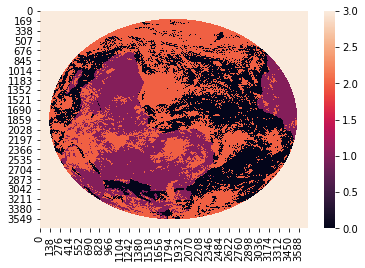

In [218]:
cloudMask = xr.open_dataset(sat_files[0], engine = 'pynio') # engine cfgrib lapt
#rint(cloudMask)
# = cloudMask['p260537'].values.reshape( (3712, 3712) )
o = cloudMask['CLOUDM_P30_GSV0_I207'].values.reshape( (3712, 3712) )
sns.heatmap(o)
plt.show()

In [219]:
import glob
import xarray as xr
import numpy as np

def timestamp(filename):
    """
    Returns the numpy datetime 64 [ns] for the current date.
    This is a bit hardcoded at the moment ....
    """
    splits = filename.split('-')
    ts = splits[5]
    year = ts[:4]
    month = ts[4:6]
    day = ts[6:8]
    hr = ts[8:10]
    minuts = ts[10:12]
    sek = ts[12:14]
    # TODO make sure all filenames have seconds
    return np.datetime64( year+"-"+month+"-"+day+"T"+hr+":"+minuts+":"+sek )

def merge_ts_to_one_dataset(grb_files, 
                            lat = np.arange(30.0, 50.25, 0.25), 
                            lon = np.arange(-15.0, 25.25, 0.25)):
    """
    grib_files : list of files
        typically one year?
    """
    data_grid = get_dict_with_all_keys()
    
    counter = 0
    for filename in grb_files:
        if counter == 0:
            #print("enters 0")
            #clou = calc_all(filename, nc_file = nc_files[0])
            cloud_fraction, nans = compute(filename, lat, lon)
            ds = xr.Dataset({'tcc': (['latitude', 'longitude'],   cloud_fraction),
                             'nr_nans':(['latitude', 'longitude'], nans),
                             #'nr_cells':(['latitude', 'longitude'], cnt_cells)
                                 },
                             coords={'longitude': (['longitude'], lon),
                                     'latitude': (['latitude'], lat),
                                    })

            ts = timestamp(filename)
            ds['time'] = ts

            # Add time as a coordinate and dimension.
            ds = ds.assign_coords(time = ds.time)
            ds = ds.expand_dims(dim = 'time')
            counter += 1

        else:
            #clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
            cloud_fraction, nans = compute(filename, lat, lon)
            new_ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  cloud_fraction),
                                 'nr_nans':(['latitude', 'longitude'], nans),
                                 #'nr_cells':(['latitude', 'longitude'], cnt_cells)
                                },
                                  coords={'longitude': (['longitude'], lon),
                                          'latitude': (['latitude'], lat),
                                           })

            ts = timestamp(filename)
            new_ds['time'] = ts

            # Add time as a coordinate and dimension.
            new_ds = new_ds.assign_coords(time = new_ds.time)
            new_ds = new_ds.expand_dims(dim = 'time')
            
            try:          
                ds = ds.merge(new_ds)
            except xr.MergeError:
                # Happens if MS1 and MS2 have taken a image at the same time
                print("Filename not included {}".format(filename))
                
            counter += 1
        #print("completed {}/{} files".format(counter, len(grb_files)))
    return ds


In [220]:
grid, nan_grib = compute(sat_files[0])

In [221]:
grid.shape

(81, 161)

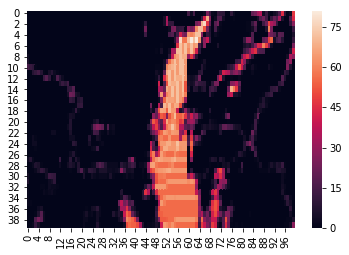

In [222]:
sns.heatmap(grid[:40, :100])

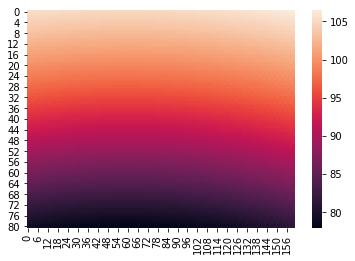

In [223]:
sns.heatmap(nan_grib)

In [224]:
o = clean_file(sat_files[0])
d_phi, d_theta, cell_areas, lat_array, lon_array = read_dlon_dlat(data_dir)
clouds = o.reshape(-1)

In [225]:
cmk = clouds.reshape((3712, 3712))

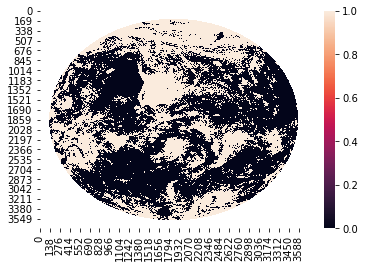

In [226]:
sns.heatmap(cmk)

In [228]:
cmk

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)

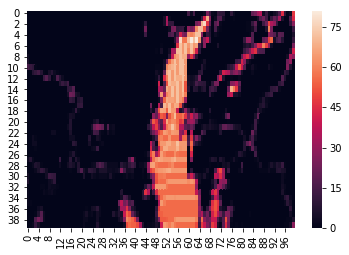

In [227]:
sns.heatmap(grid[:40, :100])

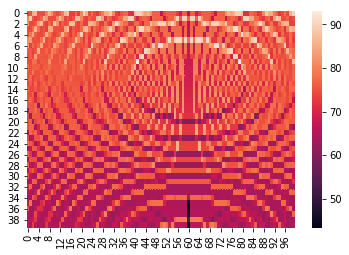

In [62]:
sns.heatmap(nan_grib[:40, :100])

In [75]:
lat_array.reshape()

803.2222606476989

In [71]:
lat_mask = (lat_array < 50)
idx_lat = lat_array[lat_mask]

In [72]:
idx_lat

30.001291275024414

In [73]:
30 < lat_array < 50

False

In [74]:
len(lat_array)

645166

In [32]:
sat_files[0]

'/uio/lagringshotell/geofag/projects/miphclac/hannasv/MSG3-SEVI-MSGCLMK-0100-0100-20140802130000.000000000Z-20140802131305-1361402.grb'

In [125]:
ds  = merge_ts_to_one_dataset(sat_files[:2])

In [124]:
ds

<xarray.Dataset>
Dimensions:    (latitude: 81, longitude: 161, time: 2)
Coordinates:
  * time       (time) datetime64[ns] 2004-07-23T19:00:00 2004-07-23T20:00:00
  * latitude   (latitude) float64 30.0 30.25 30.5 30.75 ... 49.5 49.75 50.0
  * longitude  (longitude) float64 -15.0 -14.75 -14.5 -14.25 ... 24.5 24.75 25.0
Data variables:
    tcc        (time, latitude, longitude) float64 0.0 0.0 0.0 ... 14.25 16.36
    nr_nans    (time, latitude, longitude) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0

In [119]:
import seaborn as sns

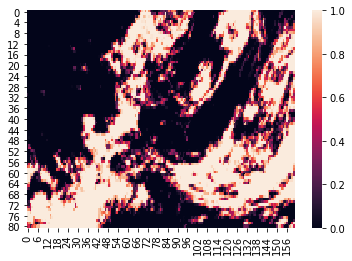

In [126]:
sns.heatmap(ds['tcc'].values[0, :, :])

In [127]:
import multiprocessing as mp

In [129]:
from multiprocessing import Process

def f(subset, i):
    
    ds = merge_ts_to_one_dataset(subset, 
                                 lat =  np.arange(30.0, 50.25, 0.25) , 
                                 lon = np.arange(-15.0, 25.25, 0.25) )

    ds.to_netcdf(path = save_dir+'cloud_fractions_heilt_nytt{}.nc'.format(i), 
                 engine='netcdf4',  
                 encoding ={'tcc': {'zlib': True, 'complevel': 9},
                           'nr_nans': {'zlib': True, 'complevel': 9} })
    return 

In [130]:
size = len(sat_files)

In [131]:
size/(200)

468

In [ ]:
for j, sub in enumerate(np.array_split(sat_files, 200)):
    alls = np.array_split(sub, 50) #np.array_split(sat_files, 100)

    processes = []
    for i, subset in enumerate(alls):
        print("Starts thread {}".format(i+j*i))
        p = Process(target=f, args=(subset, i+j*i))
        p.start()
        processes.append(p)

    for p in processes:
        p.join()
        
    print('Finished {}/{}'.format(i+j*i+1, len(alls)))

Starts thread 0
Starts thread 1
Starts thread 2
Starts thread 3
Starts thread 4
Starts thread 5
Starts thread 6
Starts thread 7
Starts thread 8
Starts thread 9
Starts thread 10
Starts thread 11
Starts thread 12
Starts thread 13
Starts thread 14
Starts thread 15
Starts thread 16
Starts thread 17
Starts thread 18
Starts thread 19
Starts thread 20
Starts thread 21
Starts thread 22
Starts thread 23
Starts thread 24
Starts thread 25
Starts thread 26
Starts thread 27
Starts thread 28
Starts thread 29
Starts thread 30
Starts thread 31
Starts thread 32
Starts thread 33
Starts thread 34
Starts thread 35
Starts thread 36
Starts thread 37
Starts thread 38
Starts thread 39
Starts thread 40
Starts thread 41
Starts thread 42
Starts thread 43
Starts thread 44
Starts thread 45
Starts thread 46
Starts thread 47
Starts thread 48
Starts thread 49
Finished 50/50
Starts thread 0
Starts thread 2
Starts thread 4
Starts thread 6
Starts thread 8
Starts thread 10
Starts thread 12
Starts thread 14
Starts thread 

Process Process-61:
Traceback (most recent call last):
  File "/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-129-4f17042f2354>", line 7, in f
    lon = np.arange(-15.0, 25.25, 0.25) )
  File "<ipython-input-121-7ee02fa4df01>", line 35, in merge_ts_to_one_dataset
    cloud_fraction, nans = compute(filename, lat, lon)
  File "<ipython-input-105-75fd93db6df6>", line 5, in compute
    o = clean_file(satfil)
  File "<ipython-input-88-e29f7fa05f61>", line 4, in clean_file
    o = cloudMask['p260537'].values.reshape( (3712, 3712) )
  File "/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/xarray/core/dataarray.py", line 407, in values
    return self.variable.values
  File "/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7

Finished 99/50
Starts thread 0
Starts thread 3
Starts thread 6
Starts thread 9
Starts thread 12
Starts thread 15
Starts thread 18
Starts thread 21
Starts thread 24
Starts thread 27
Starts thread 30
Starts thread 33
Starts thread 36
Starts thread 39
Starts thread 42
Starts thread 45
Starts thread 48
Starts thread 51
Starts thread 54
Starts thread 57
Starts thread 60
Starts thread 63
Starts thread 66
Starts thread 69
Starts thread 72
Starts thread 75
Starts thread 78
Starts thread 81
Starts thread 84
Starts thread 87
Starts thread 90
Starts thread 93
Starts thread 96
Starts thread 99
Starts thread 102
Starts thread 105
Starts thread 108
Starts thread 111
Starts thread 114
Starts thread 117
Starts thread 120
Starts thread 123
Starts thread 126
Starts thread 129
Starts thread 132
Starts thread 135
Starts thread 138
Starts thread 141
Starts thread 144
Starts thread 147
Finished 148/50
Starts thread 0
Starts thread 4
Starts thread 8
Starts thread 12
Starts thread 16
Starts thread 20
Starts t

In [ ]:
ds

In [ ]:
new_ds

In [ ]:
len(alls)

In [ ]:
for t in ds.time.values:
    ax = sns.heatmap(ds.sel(time = t)['tcc'].values)
    ax.set_title(t)
    plt.savefig('/home/hanna/{}.png'.format(t))
    plt.show()

In [ ]:
ds.sel(time = '2004-07-23T19:00:00')['tcc'].values

In [ ]:
sns.heatmap(ds.sel(time = '2004-07-23T19:00:00')['tcc'].values)

# Write file and generate filename.

In [ ]:
def output_filename(var, start, stop, add_text_begin = ""):
    """
    Add test train or valid in front when this is appropriate.

    OBS: Var should be in terms of variables in the era-interim datasets.
    """
    return (save_dir + add_text_begin + var + "_" + start + "_" +
                stop + "_" + season_str + ".nc")
